In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\alexa\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\alexa\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv im

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn'])

# Chapter 2. Small Worlds and Large Worlds

There are two worlds:

* The **Small World** is the self-contained logical world of your model. It operates under certain assumptions. Within the small world, all possibilities are considered. Bayesian models have the advantage that they make the best use of available information to make decisions (i.e., Bayes classifier). However, this all lies on the assumption that the small world is an accurate description of the large world.


* The **Large World** is the broader context in which the model is deployed. In the large world there are events that were not imagined in the small world, like a large continent between Europe and Asia. The model is always an incorrect representation of the large world to some extent---The logical consistency of a model in the small world is no guarantee that it will be optimal in the large world.



***

## Probabilities in the garden of forking data

A Bayesian analysis is like walking through the garden of forking paths--all alternative sequences of events are evaluated (when data get large, we instead approximate).

We are trying to guess between different state of the world given a small amount of data. To do this, we try to guess *how the data were generated*. States of the world that have *more ways of producing the observed data* are *more likely*.

Ex. Imagine there is a bag containing four marbles. There are either blue or white marbles in the bag. We sample three times with replacement and get BWB. What are the most probable contents of the bag?

If we look at each possible state (or conjecture) and count the number of ways that they could have produced the data, we can see that BBWW and BBBW are the most likely because they have more ways that they could have produced the data.

|   |   |   |  ||
|----|----|----|---|--------------|
| W  | W  | W  | W | 0 × 4 × 0 = 0
| B  | W  | W  | W | 1 × 3 × 1 = 3
| B  | B  | W  | W | 2 × 2 × 2 = 8
| B  | B  | B  | W | 3 × 1 × 3 = 9
| B  | B  | B  | B | 4 × 0 × 4 = 0


What we've just described here is the **likelihood**. Bayesian inference also makes use of **prior probabilities**:

Say for example we know in advance how common each of the different states are:

|   |   |   |  | Likelihood | Prior | New Count
|----|----|----|---|--| --- | --- |
| W  | W  | W  | W | 0 | 0 | 0
| B  | W  | W  | W | 3 | 1 | 3
| B  | B  | W  | W | 8 | 2 | 16
| B  | B  | B  | W | 9 | 3 | 27
| B  | B  | B  | B | 0 | 4 | 0

Note that the actual counts don't matter---only their relative counts. If we want to convert this into probabilities, we will add a normalization step, where we divide the count by the total sum to get the probability of each:

In [3]:
# Calculate the number of ways to arrive at BWB under each conjecture
prior =      np.array([0, 1, 2, 3, 4])
likelihood = np.array([0, 3, 8, 9, 0])

counts = np.multiply(prior, likelihood)
print(counts)

[ 0  3 16 27  0]


In [4]:
# Normalize by the total number of possibilities to get the posterior probability
posterior = counts / np.sum(counts)
print(posterior)

[0.         0.06521739 0.34782609 0.58695652 0.        ]


***

## Bayes' Theroem

In essence, the example above is Bayes' Theorem:

$$Posterior = \frac{Likelihood * Prior}{Average Likelihood}$$

In more mathy terms, it looks like this:

$$ Pr(P=p|X=x) = \frac{Pr(X=x|P=p)*Pr(P=p)}{Pr(X=x)} $$

(For simplicity, $P=p$ will be represented as $p$ and $X=x$ as $x$

Where $p$ is the parameter that represents the proportion of blue marbles in the bag, and $x$ is the observed data (proportion of blue marbles that we really observed).

* $Pr(x)$ is the probability of observing the data. It is merely a normalization constant, but it is also the most difficult component to estimate because to get the probability of observing the data, we have to determine the probability of observing the data for all possible values of $P$ (ie., the conditional probability of $x$ for all possible $P$ [eg., $p_1, ... p_n$, with $p$ being just one of these possibilities]).


* $Pr(p)$ is the prior probability that $P=p$.


* $Pr(x|p)$ is the probability that the data were observed assuming that $P$ = $p$ is the true state. This is where counting comes in---The more ways there are to generate the data given state $p$, the more likely it is to be the true state.

***

## Building a Bayesian Model

There are three steps:

1. **Data Story**: Describe the process by which the data were created. It can be descriptive, specifying associations that can be used to predict outcomes, or it can be causal, such that one event produces another.

2. **Bayesian Updating**: As data are collected, update the posterior probability.

3. **Evaluate**: The Bayesian model learns in a way that is optimal, provided that the real, large world is accurately described by the model. That is to say that the Bayesian model guarantees perfect inference in the small world. However, there are still a few major points to consider:


* The model's certainty is no guarantee that it is good. As the amount of data increases, your model may become increasingly confident. But models of all sorts (not just Bayesian models) can be confident about an estimate and still be very misleading. The model is telling you that it is confident in its estimates, but **this assumes a commitment to the particular model**. For example, when drawing marbles out of a bag we assume that they are sufficiently shuffled between each draw.


* Second, it is important to check and critique your model's work. There may be elements that affect performance in the real world, but do not matter (or are not captured) in the model. This is discussed more in Chapter 3. The objective here is not to test the model's assumptions for correctness---they never are. Instead, we are testing that the model is adequate for its purpose.

***

### 2.3 Components of the model

There are three major components of a Bayesian model that must be 'chosen':

1. The **likelihood function**

2. The **parameters**

3. The **prior**


#### 2.3.1 Likelihood

The likelihood is a mathematical formula that specifies the plausibility of the data. What this means is that the likelihood function maps each conjecture (eg., the proportion of water on the surface of the Earth) onto the number of ways the data could occur, assuming that conjecture is the truth.

The likelihood function can be built based on your data story, or it can be a formula taken off the shelf. In either case, it will need to return the probability of any possible observation for any possible state of the (small) world.

In the case of tossing a globe to estimate the proportion of water, we have the following assumptions:


1. There are two outcomes: Water (W) and Land (L). In the small world, we ignore all other outcomes (eg. the globe is dropped)

2. The proportion of water (i.e., the probability of $w$) is constant

3. Each toss is independent of oher tosses.


Given these assumptions, the **binomial distribution** is an appropriate choice:


$$Pr(w \mid n, p) =  \frac{n!}{w!(n − w)!} p^w (1 − p)^{n−w}$$


The above can be read as:

*The count of water observations ($w$) is distributed binomially, with probability of water ($p$) on each toss and in $n$ total tosses.*

In [5]:
# Evaluate the probability of observing 6 W's out of 9 tosses, under the conjecture that p = 0.5
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000006

In [6]:
# Evaluate the probability of observing 6 W's out of 9 tosses, under the conjecture that p = 0.7
stats.binom.pmf(6, n=9, p=0.7)

0.2668279319999999

Given these data, the likelihood that $p=0.7$ is greater than the likelihood that $p=0.5$

#### 2.3.2 Parameters

Most likelihood functions have adjustable inputs---these are parameters. Different parameters represent different conjectures / explanations for the data. In this example, the probability of seeing a W ($p$), the sample size ($n$), and the observed number of Ws ($w$) are all parameters. However, as both $n$ and $w$ are observed in the data, $p$ is the only *unknown* paramaeter.

Note that more than one parameters can be unknown. In ecology, for example, capture-recapture experiments attempt to estimate both $n$ and $p$.

In many types of data analysis, parameters and data are different kinds of entities---data are known and parameters are unknowns that are estimated from the data. In the Bayesian framework, the distinction becomes fuzzy. A datum can be viewed as very narrow probability density for a parameter, and a parameter as a datum with uncertainty.

#### 2.3.3 Priors

For every parameter you intend to estimate in your Bayesian machine, you must provide a *prior*. The prior is the initial set of plausibilities. When $n$ = 0, there must be some initial value for the parameter $p$.

Priors have two important effects on the model:

1. **They constrain the range of possible values of the parameter.** We know from the start that $p=0$ or $p=1$ are impossible, because some land and some water must exist. As another example, if we encode a prior where there is a 0% chance that there is more land than water on the globe, the posterior will never drop below $p=0.5$ regardless of the data.

2. **They encode prior knowledge about the world.** Even before tossing the globe we have some sense that the Earth's surface is mostly water. We also know that values near $p=0$ or $p=1$ are less likely than ones near $p=0.5$. We can encode this knowledge in our prior.

Often a flat prior is used. However, a flat prior is rarely ever the best prior. Often a *regularizing* or *weakly informative* prior produces better inference. Mathematically equivalent approaches, *penalized likelihoods* have been adopted in non-Bayesian procedures as well. These priors tend to be conservative and aim against overfitting.


*Subjective Bayesian* analysis follows the thought that the prior should be based on the subjective beliefs of the analyst. This rarely happens in science, as the prior is considered part of the model---it should be chosen, evaluated, and revised just like all of the other components of hte model.

This is not to say that statistics are not inherently subjective. These is also no reason that we must only use one prior. Each prior encodes certain assumptions about the world (eg., there is more water than land); we should interrogate the priors just as we interrogate any other assumptions. Testing the model's sensitivity to several priors is wise.



##### Lying with priors

It is true that you can obtain any result that you want by changing a prior. But it is also a terrible way to lie about your analyses because the choice of prior is so transparent. A much easier way to lie about your data is to use an opaque model, or better yet to massage the data, such as removing outliers or performing motivated transformations.

While it is true that choosing a likelihood function has become much more *conventionalized* than choosing a prior, conventional choices are often poor ones. They may still influence your analyses, but in ways that may be hard to disocver.

While non-Bayesian procedures don't have to select priors, they still have to make other choices that Bayesian ones do not, like the estimator or likelihood penalty. Often, these choices can be equivalent to selecting certain priors.

#### 2.3.4 Posterior

For every unique combination of data, likelihood, parameters, and prior, there is a unique set of estimates. These estimates---the relative plausibility of different parameter values, conditional on the data---are known as the *posterior distribution*.

The posterior takes the form of the: $Pr(P=p|n, X=x)$. That is, the probability of $p$ conditional on the data.

***

### 2.4 Approximations with Conditioning Engines

Bayesian models are computationally expensive, and many problems cannot be conditioned formally. Instead, we use conditioning engines that approximate Bayes' theorem. The selection of conditioning engine becomes, itself, part of the model. In this book, three are discussed:

1. Grid approximation (very intensive)

2. Quatratic approximation (very approximate)

3. Markov chain Monte Carlo (intensive)


#### 2.4.1 Grid Approximation

While most parameters are continuous, we can achieve very good results by taking the continuous posterior distribution and considering only a finite grid of parameter values. At every value of a parameter $p'$ of the posterior, we simply compute the probability from the prior and likelihood. Repeating this procedure for every value of the grid generates an approximate picture of the continuous posterior distribution. As the grid becomes more granular, the approximated posterior becomes more and more similar to the true posterior.


Grid approximation is useful for thinking about how Bayesian updating works. However, it scales poorly as the number of paramters increases, and is not ofen used in real modeling.

In the context of the globe example, here is how the recipe works:

1. **Define the grid** (ie., how many points to use to estimate the posterior).

2. **Compute the value of the prior** at each parameter value on the grid.

3. **Compute the value of the likelihood** at each parameter value on the grid.

4. **Compute the unstandardized posterior** at each parameter value.

5. **Standardize the posterior** by dividing each step by the sum of all values.

In [7]:
def posterior_grid_approx(grid_points=5, success=6, tosses=9):
    # 1. define grid
    p_grid = np.linspace(0, 1, grid_points)

    # 2. define prior
#     prior = np.repeat(5, grid_points)  # uniform
#     prior = (p_grid >= 0.5).astype(int)  # truncated at 0.5
    prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp; peaked at 0.5

    # 3. compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # 4. compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # 5. standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return p_grid, posterior


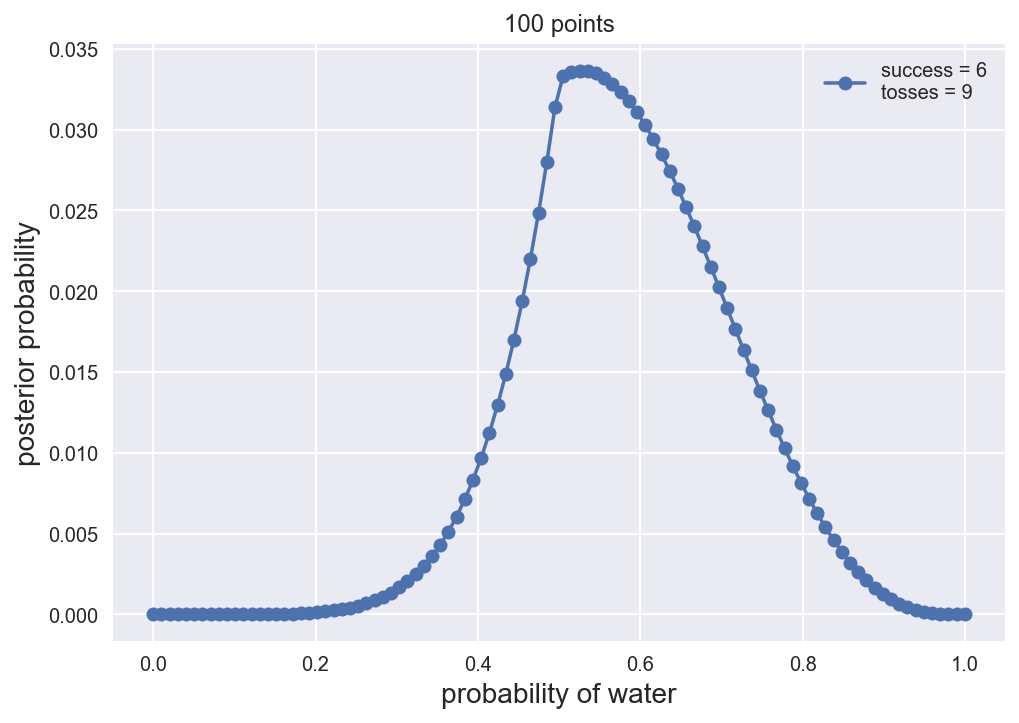

In [8]:
points = 100
w = 6
n = 9
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, 'o-', label='success = {}\ntosses = {}'.format(w, n))
plt.xlabel('probability of water', fontsize=14)
plt.ylabel('posterior probability', fontsize=14)
plt.title('{} points'.format(points))
plt.legend(loc=0);

#### Quadratic Approximation

Grid approximation grows quadratically as the number of parameters increases. A $1 * 100$ grid is simple enough, but for two parameters, $100^{2} = 10000$. For 10 parameters, the grid becomes billions of values.

Another useful approximation technique is *quadratic approximation*. Under many conditions, the posterior distribution can be approximated quite well by a Gaussian distribution. This is convenient, because a Gaussian distribution can be summarized by two parameters. The quadratic distribution is named as such because the $log$ of a Gaussian distribution is a parabola, which is a quadratic function---so this approximation represents any log-posterior with a parabola. For many problems, like linear regression, quadratic appoximation works very well.


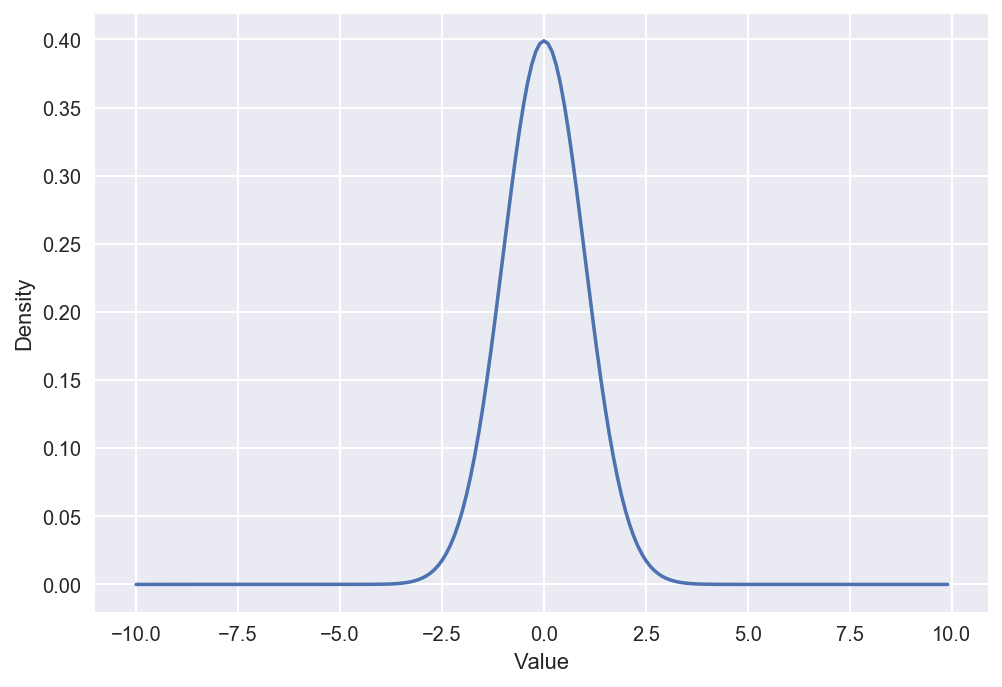

In [9]:
# A Gaussian distribution; probability (density) vs. value

size = np.arange(start=-10, stop=10, step=0.1)
norm_example =stats.norm.pdf(size)

plt.ylabel('Density')
plt.xlabel('Value')
plt.plot(size, norm_example)

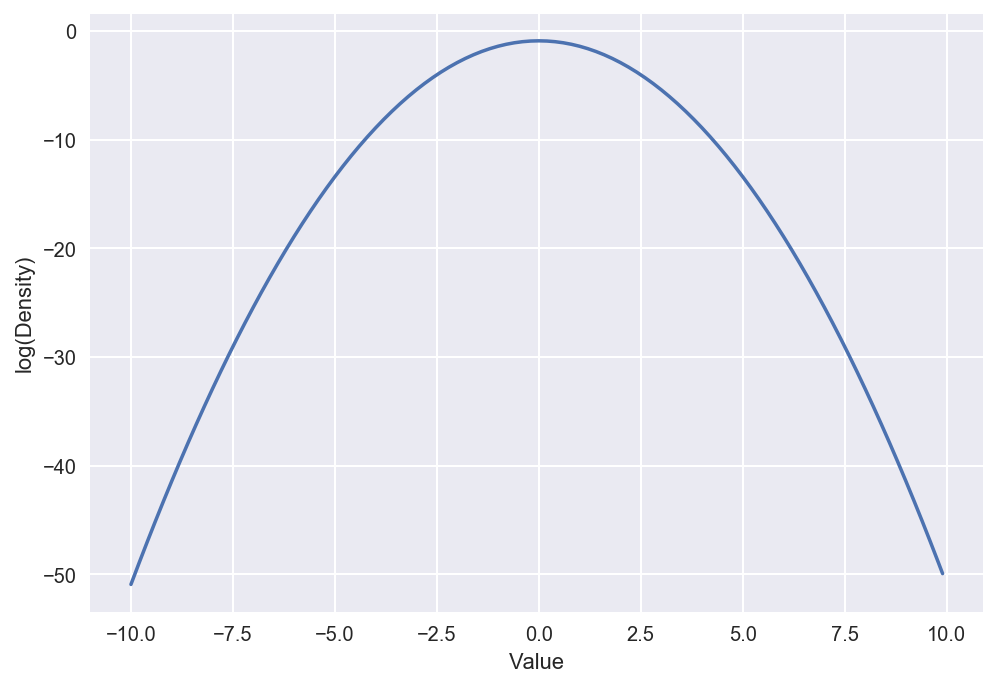

In [10]:
plt.ylabel('log(Density)')
plt.xlabel('Value')
plt.plot(size, np.log(norm_example))


The steps to perform quadratic approximation are as follows:

1. **Find the mode of the posterior** (aka the *maximum a posteriori* [MAP]). Note that the mode of the normal distribution is equivalent to its mean. Simple hill-climbing algorithms can be used to identify peaks.

2. **Estimate the curvature near the peak.** In many cases, this curvature is sufficient to compute a quadratic approximation of the entire posterior. In some cases this can be done analytically, but usually the computer uses some numerical technique instead.

In [11]:
# Generate globe-tossing data
data = np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])

# Construct distributions
with pm.Model() as normal_approximation:
    p = pm.Uniform('p', 0, 1)    # uniform prior
    w = pm.Binomial('w', n=len(data), p=p, observed=data.sum())    # binomial likelihood
    

In [12]:
normal_approximation
# p is the prior
# w is the likelihood function

In [13]:
# Find the mode (which corresponds to the mean of the distribution) and the standard deviation
with normal_approximation:
    mean = pm.find_MAP()
    sd = ((1/pm.find_hessian(mean, vars=[p]))**0.5)[0]

print(mean['p'], sd)

logp = -1.8075, ||grad|| = 1.5: 100%|██████████████████████████████████████████████████| 7/7 [00:00<00:00, 1169.87it/s]


0.6666666671652423 [0.15713484]


In [14]:
norm = stats.norm(mean, sd)    # generate a normal distribution
prob = .90    # 90% percentile interval

# percent point function; returns percentile point of the observation. The inverse of the cdf
z = stats.norm.ppf([(1-prob)/2, (1+prob)/2])
pi = mean['p'] + sd * z

print(pi)

[0.40820286 0.92513048]


Our quadratic approximation has returned a MAP value of $p=0.67$ and $sd=0.157$. Also our 90% percentile interval is $0.408 - 0.925$ Since we can calculate the posterior analytically, we can check how good our approximation was.

But before doing that, we will compute the quadratic approximation again, except with a larger sample size. We will be able to compare how good each of these approximations fare compared to the true posterior.

In [15]:
# Repeat the above steps for quadratic approximation except with larger sample size
data2 = np.repeat(data, 4)

with pm.Model() as normal_approximation2:
    p2 = pm.Uniform('p2', 0, 1)  # uniform prior
    w2 = pm.Binomial('w2', n=len(data2), p=p2, observed=data2.sum())  # binomial likelihood

with normal_approximation2:
    mean2 = pm.find_MAP()
    sd2 = ((1/pm.find_hessian(mean2, vars=[p2]))**0.5)[0]

print(mean2['p2'], sd2)

logp = -4.0055, ||grad|| = 6: 100%|████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1412.56it/s]


0.6666666671652423 [0.07856742]


It should not be surprising that by replicating the data 4 times the mean is the same, but the standard deviation has decreased by half.

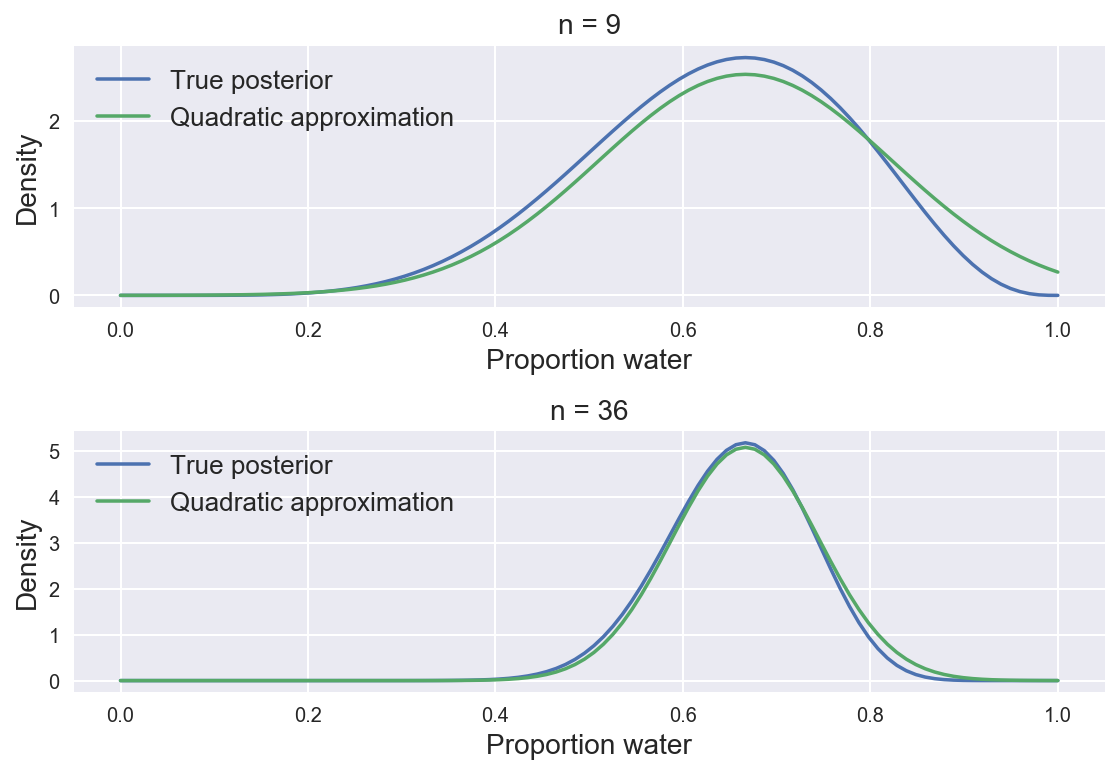

In [16]:
# analytical calculation (the math here is not explained)

x = np.linspace(0, 1, 100)

w, n = 6, 9
plt.subplot(211)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean['p'], sd),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);
plt.tight_layout()

### 
w, n = 24, 36
plt.subplot(212)
plt.plot(x, stats.beta.pdf(x , w+1, n-w+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean2['p2'], sd2),
         label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title('n = {}'.format(n), fontsize=14)
plt.xlabel('Proportion water', fontsize=14)
plt.ylabel('Density', fontsize=14);
plt.tight_layout()


It can be seen from the plot that the quadratic approximation is quite close on the left end of the posterior, but rather poor on the right. However, as the sample size increases, the approximation improves.

Indeed, this is why traditional statistical methods that rely on the quadratic approximation are so nervous when sample sizes are small. These procedures are only truly safe with infinite data, but they are often useful with much less. The rate of improvement varies a lot depending on the details, so there isn't a set sample size after which this approximation will work "well".

The quadratic approximation with a uniform prior or a large amount of data is more-or-less equivalent to the **maximum likelihood estimate** (a very common non-Bayesian parameter estimate) and its standard error.


#### Markov Chain Monte Carlo

For many model types, neither grid approximation nor quadratic approximation are suitable. MCMC is a family of counterintuitive model fitting techniques that are extremely powerful.

They are counterintuitive because instead of approximating the posterior distribution directly, MCMC techniques only draw samples from the posterior. You can obtain parameter values from large number of samples and then build the posterior from the histogram of the samples. 

MCMC is the main technique used in most Bayesian modeling, and is discussed in greater detail throughout the book.


***

## Exercises

### Easy

***

2E1. Which of the expressions below correspond to the statement: the probability of rain on Monday?

(1) Pr(rain)

**(2) Pr(rain|Monday)**

(3) Pr(Monday|rain)

(4) Pr(rain; Monday)= Pr(Monday)

***

2E2. Which of the following statements corresponds to the expression: Pr(Monday|rain)?

(1) The probability of rain on Monday.

**(2) The probability of rain, given that it is Monday.**

(3) The probability that it is Monday, given that it is raining.

(4) The probability that it is Monday and that it is raining

***

2E3. Which of the expressions below correspond to the statement: the probability that it is Monday,
given that it is raining?

**(1) Pr(Monday|rain)**

(2) Pr(rain|Monday)

(3) Pr(rain|Monday) * Pr(Monday)

**(4) Pr(rain|Monday) * Pr(Monday)/ Pr(rain)**

(5) Pr(Monday|rain) * Pr(rain)/ Pr(Monday)

***

2E4. The Bayesian statistician Bruno de Finetti (1906–1985) began his book on probability theory with the declaration: “PROBABILITY DOES NOT EXIST.” The capitals appeared in the original, so I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a device for describing uncertainty from the perspective of an observer with limited knowledge; it has no objective reality. Discuss the globe tossing example from the chapter, in light of this statement. What does it mean to say “the probability of water is 0.7”?

**The true proportion of water on the globe is fixed. The 'probability of water' is simply a proxy for the true proportion of water in our "small world" model.**

#### Medium

***

**2M1.** Recall the globe tossing model from the chapter. Compute and plot the grid approximate posterior distribution for each of the following sets of observations. In each case, assume a uniform prior for p.

(1) W, W, W

(2) W, W, W, L

(3) L, W, W, L, W, W, W

In [17]:
# I previously defined a function for this, but for practice I will redefine it:

def grid_approx_globe_toss(data, n_grids=100, prior_dist=1):
    # Define a grid
    x = np.linspace(0, 1, n_grids)    # 0 to 1 with steps of 0.05 by default

    # Compute the prior at each parameter on the grid
    if prior_dist == 1:
        prior = stats.uniform.pdf(x)
    if prior_dist == 2:
        prior = x >= 0.5

    # Compute the likelihood at each parameter value
    likelihood = stats.binom.pmf(data.sum(), len(data), x)

    # Compute the unstandardized posterior at each parameter value
    unstd_posterior = likelihood * prior

    # Compute the standardized posterior
    posterior = unstd_posterior / unstd_posterior.sum()
    
    return posterior

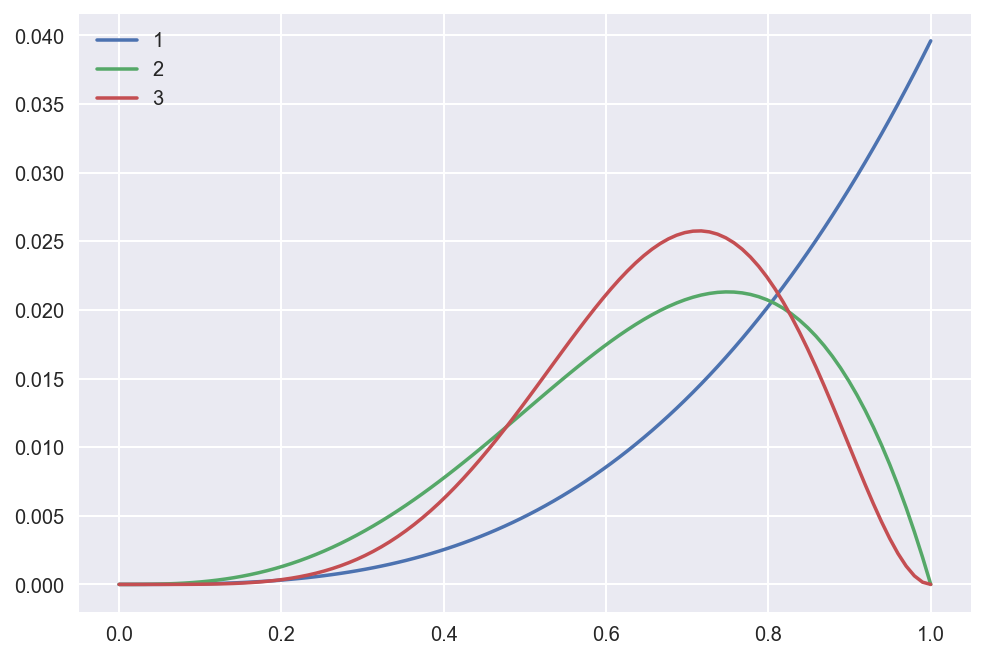

In [18]:
# Uniform prior, different data

#1
posterior = grid_approx_globe_toss(np.array([1, 1, 1]))
plt.plot(x, posterior, label = '1')
plt.legend()

#2
posterior = grid_approx_globe_toss(np.array([1, 1, 1, 0]))
plt.plot(x, posterior, label = '2')
plt.legend()

#3
posterior = grid_approx_globe_toss(np.array([0, 1, 1, 0, 1, 1, 1]))
plt.plot(x, posterior, label = '3')
plt.legend()


***

**2M2.** Now assume a prior for p that is equal to zero when p < 0:5 and is a positive constant when p ≥ 0:5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above

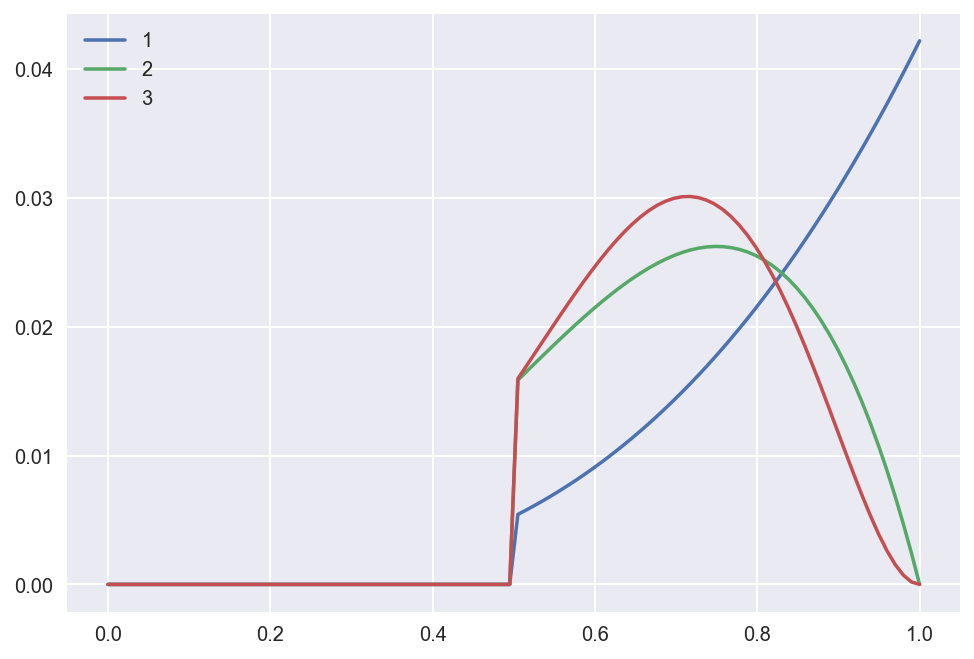

In [19]:
# Same data sets as above; different prior

#1
posterior = grid_approx_globe_toss(np.array([1, 1, 1]), prior_dist = 2)
plt.plot(x, posterior, label = '1')
plt.legend()

#2
posterior = grid_approx_globe_toss(np.array([1, 1, 1, 0]), prior_dist = 2)
plt.plot(x, posterior, label = '2')
plt.legend()

#3
posterior = grid_approx_globe_toss(np.array([0, 1, 1, 0, 1, 1, 1]), prior_dist = 2)
plt.plot(x, posterior, label = '3')
plt.legend()

***

**2M3.** Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered
in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know
which—was tossed in the air and produced a “land” observation. Assume that each globe was equally
likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on
seeing “land” (Pr(Earth|land)), is 0.23

In [20]:
p_LandEarth = 0.3
p_LandMars = 1
p_Earth = 0.5
p_Mars = 1 - p_Earth


p_Land = (p_LandEarth * p_Earth + p_LandMars * p_Mars)

p_EarthLand = p_LandEarth * p_Earth / p_Land

p_EarthLand

0.23076923076923075

***

**2M4.** Suppose you have a deck with only three cards. Each card has two sides, and each side is either
black or white. One card has two black sides. The second card has one black and one white side. The
third card has two white sides. Now suppose all three cards are placed in a bag and shufed. Someone
reaches into the bag and pulls out a card and places it ﬂat on a table. A black side is shown facing up,
but you don’t know the color of the side facing down. Show that the probability that the other side is
also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This
means counting up the ways that each card could produce the observed data (a black side facing up
on the table).

In [21]:
# Uniform probability of each card before the first reveal
p_Card1 = 1/3
p_Card2 = 1/3
p_Card3 = 1/3


# probability that side 1 is black
p_Blk1Card1 = 2/2
p_Blk1Card2 = 1/2
p_Blk1Card3 = 0/2

# probability of each card after the first reveal
p_Card1Blk1 = p_Card1 * p_Blk1Card1; print('Card 1, first reveal:' + str(p_Card1Blk1))
p_Card2Blk1 = p_Card2 * p_Blk1Card2; print('Card 2, first reveal:' + str(p_Card2Blk1))
p_Card3Blk1 = p_Card3 * p_Blk1Card3; print('Card 3, first reveal:' + str(p_Card3Blk1))

# probability of black on first reveal
p_Blk1 = (p_Card1Blk1 + p_Card2Blk1 + p_Card3Blk1); print('Probability of black on first reveal:' + str(p_Blk1))

# probability that side 2 is black, given that side 1 is black
p_Blk2Blk1Card1 = 1/1
p_Blk2Blk1Card2 = 0/1
p_Blk2Blk1Card3 = 0

p_Blk2Blk1 = (p_Card1Blk1 * p_Blk2Blk1Card1 + p_Card2Blk1 * p_Blk2Blk1Card2 + p_Card3Blk1 * p_Blk2Blk1Card3) / p_Blk1

print('Probability that the second face is black, given that the first is black: ' + str(p_Blk2Blk1))


Card 1, first reveal:0.3333333333333333
Card 2, first reveal:0.16666666666666666
Card 3, first reveal:0.0
Probability of black on first reveal:0.5
Probability that the second face is black, given that the first is black: 0.6666666666666666


***

**2M5.** Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is
drawn from the bag and a black side appears face up. Again calculate the probability that the other
side is black

In [22]:
# Uniform probability of each card before the first reveal
p_Card1 = 1/4
p_Card2 = 1/4
p_Card3 = 1/4
p_Card4 = 1/4


# probability that side 1 is black
p_Blk1Card1 = 2/2
p_Blk1Card2 = 1/2
p_Blk1Card3 = 0/2
p_Blk1Card4 = 2/2

# probability of each card after the first reveal
p_Card1Blk1 = p_Card1 * p_Blk1Card1; print('Card 1, first reveal:' + str(p_Card1Blk1))
p_Card2Blk1 = p_Card2 * p_Blk1Card2; print('Card 2, first reveal:' + str(p_Card2Blk1))
p_Card3Blk1 = p_Card3 * p_Blk1Card3; print('Card 3, first reveal:' + str(p_Card3Blk1))
p_Card4Blk1 = p_Card4 * p_Blk1Card4; print('Card 4, first reveal:' + str(p_Card4Blk1))

# probability of black on first reveal
p_Blk1 = (p_Card1Blk1 + p_Card2Blk1 + p_Card3Blk1 + p_Card4Blk1); print('Probability of black on first reveal:' + str(p_Blk1))

# probability that side 2 is black, given that side 1 is black
p_Blk2Blk1Card1 = 1/1
p_Blk2Blk1Card2 = 0/1
p_Blk2Blk1Card3 = 0
p_Blk2Blk1Card4 = 1/1

p_Blk2Blk1 = (p_Card1Blk1 * p_Blk2Blk1Card1 + p_Card2Blk1 * p_Blk2Blk1Card2 + p_Card3Blk1 * p_Blk2Blk1Card3 + p_Card4Blk1 * p_Blk2Blk1Card4) / p_Blk1

print('Probability that the second face is black, given that the first is black: ' + str(p_Blk2Blk1))



Card 1, first reveal:0.25
Card 2, first reveal:0.125
Card 3, first reveal:0.0
Card 4, first reveal:0.25
Probability of black on first reveal:0.625
Probability that the second face is black, given that the first is black: 0.8


***

**2M6.** Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white
sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume
there are three cards: B/B, B/W, and W/W. Afer experimenting a number of times, you conclude that
for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to
pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that
the probability the other side is black is now 0.5. Use the counting method, as before.

In [23]:
# Uniform probability of each card before the first reveal
p_Card1 = 1 / 6
p_Card2 = 2 / 6
p_Card3 = 3 / 6


# probability that side 1 is black
p_Blk1Card1 = 2/2
p_Blk1Card2 = 1/2
p_Blk1Card3 = 0/2

# probability of each card after the first reveal
p_Card1Blk1 = p_Card1 * p_Blk1Card1; print('Card 1, first reveal:' + str(p_Card1Blk1))
p_Card2Blk1 = p_Card2 * p_Blk1Card2; print('Card 2, first reveal:' + str(p_Card2Blk1))
p_Card3Blk1 = p_Card3 * p_Blk1Card3; print('Card 3, first reveal:' + str(p_Card3Blk1))

# probability of black on first reveal
p_Blk1 = (p_Card1Blk1 + p_Card2Blk1 + p_Card3Blk1); print('Probability of black on first reveal:' + str(p_Blk1))

# probability that side 2 is black, given that side 1 is black
p_Blk2Blk1Card1 = 1/1
p_Blk2Blk1Card2 = 0/1
p_Blk2Blk1Card3 = 0

p_Blk2Blk1 = (p_Card1Blk1 * p_Blk2Blk1Card1 + p_Card2Blk1 * p_Blk2Blk1Card2 + p_Card3Blk1 * p_Blk2Blk1Card3) / p_Blk1

print('Probability that the second face is black, given that the first is black: ' + str(p_Blk2Blk1))



Card 1, first reveal:0.16666666666666666
Card 2, first reveal:0.16666666666666666
Card 3, first reveal:0.0
Probability of black on first reveal:0.3333333333333333
Probability that the second face is black, given that the first is black: 0.5


***

**2M7.** Assume again the original card problem, with a single card showing a black side face up. Before
looking at the other side, we draw another card from the bag and lay it face up on the table. The face
that is shown on the new card is white. Show that the probability that the frst card, the one showing
a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat
this like the sequence of globe tosses, counting all the ways to see each observation, for each possible
frst card.

In [24]:
# Using the counting method

# ways that side 1 of the first card is black
p_Blk1Card1 = 2 / 2
p_Blk1Card2 = 1 / 2
p_Blk1Card3 = 0

# Ways that side 1 of the second card is white, conditioned on the first card:
p_2Wht1Card1 = 6 / 8
p_2Wht1Card2 = 2 / 4

# Frequency of each card given 1 Black-1 and 2 White-1:
p_Card1Blk1_2Wht1 = p_Blk1Card1 * p_2Wht1Card1    # aka 2 * 6 / 8
p_Card2Blk1_2Wht1 = p_Blk1Card2 * p_2Wht1Card2    # aka 1 * 2 / 4

# Probability that the first card is card 1 (aka the other side is black)
p_Card1Blk1_2Wht1 = p_Card1Blk1_2Wht1 / (p_Card1Blk1_2Wht1 + p_Card2Blk1_2Wht1)
print(p_Card1Blk1_2Wht1)

0.75


### Hard

**2H1.** Suppose there are two species of panda bear. Both are equally common in the wild and live
in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay
capable of telling them apart. They diﬀer however in their family sizes. Species A gives birth to twins
10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise
birthing singleton infants. Assume these numbers are known with certainty, from many years of feld
research.

Now suppose you are managing a captive panda breeding program. You have a new female panda
of unknown species, and she has just given birth to twins. What is the probability that her next birth
will also be twins?

In [25]:
p_TwinsA = 0.1
p_TwinsB = 0.2

p_A = 0.5
p_B = 1 - p_A

p_ATwins = p_TwinsA * p_A / (p_A * p_TwinsA + (p_B * p_TwinsB))
p_BTwins = p_TwinsB * p_B / (p_B * p_TwinsB + (p_A * p_TwinsA))

# The probability of twins again is the probability of each species having twins * the probability of each species
p_TwinsTwins = p_TwinsA * p_ATwins + p_TwinsB * p_BTwins

p_TwinsTwins

0.16666666666666666

***

**2H2.** Recall all the facts from the problem above. Now compute the probability that the panda we
have is from species A, assuming we have observed only the frst birth and that it was twins.

In [26]:
# This has already been done
p_ATwins

0.3333333333333333

***

**2H3.** Continuing on from the previous problem, suppose the same panda mother has a second birth
and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is
species A.

In [27]:
pior = p_ATwins

p_SingleA = 1 - p_TwinsA
p_SingleB = 1 - p_TwinsB

p_SingleTwinsA = p_SingleA * p_TwinsA
p_SingleTwinsB = p_SingleB * p_TwinsB

p_ASingleTwins = p_SingleTwinsA * p_A / (p_SingleTwinsA * p_A + p_SingleTwinsB * p_B)
p_BSingleTwins = 1 - p_ASingleTwins
p_ASingleTwins

0.36

***

**2H4.** A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of
the data, even if the data are of diﬀerent types. So suppose now that a veterinarian comes along who has a new genetic test that she claims can identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:

• The probability it correctly identifes a species A panda is 0.8.

• The probability it correctly identifes a species B panda is 0.65.

The vet administers the test to your panda and tells you that the test is positive for species A. First ignore your previous information from the births and compute the posterior probability that your panda is species A. Then redo your calculation, now using the birth data as well.

In [28]:
# Part 1

p_testedA_A = 0.8
p_testedB_B = 0.65
p_testedA_B = 1 - p_testedB_B

p_A_testedA = p_testedA_A * p_A / (p_testedA_A * p_A + p_testedA_B * p_B)
p_A_testedA

0.6956521739130436

In [29]:
# Part 2
# Use the probability of having twins --> singleton as the prior

p_A_testedA_twins = p_testedA_A * p_ASingleTwins / (p_testedA_A * p_ASingleTwins + p_testedA_B * p_BSingleTwins)

p_A_testedA_twins

0.5625

***

In [30]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer AMD64 running   and using:
Python 3.6.4
IPython 6.2.1
PyMC3 3.4.1
NumPy 1.14.0
SciPy 1.0.0
Matplotlib 2.1.2

